# User defined loss functions

Here we will show how you can define your own loss functions to train a neural network.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import easysurrogate as es

In [2]:
plt.rcParams['image.cmap'] = 'seismic'

We will use a very simple analytic function `f` to generate some training data

In [3]:
def f(x1, x2):
    """
    A simple analytic function.

    Parameters
    ----------
    x1 : float or array of floats
        First input.
    x2 : float or array of floats
        Second input.

    Returns
    -------
    float or array of floats
        Function values at (x1, x2).

    """
    return np.array([np.sin(x1 ** 2), np.cos(x2)])

Generate the training data

In [4]:
n_train = 10000
X = np.random.rand(n_train, 2)
y = f(X[:, 0], X[:, 1]).T
n_out = y.shape[1]

### Squared loss and its dimensions

Here we train a standard ANN with the squared (scalar) loss function (`loss="squared"`):

\begin{align}
L = \frac{1}{n_{out}}\sum_{j=1}^{n_{out}}(y_j - h_j)^2 \in\mathbb{R}
\end{align}

Here, $y_j$ and $h_j$ are the j-th data point and ANN predictions of the j-th neuron, with $j=1,\cdots,n_{out}$. Hence their dimensions are:

Internally, the following gradient is computed:

\begin{align}
\frac{\partial L}{\partial {\bf h}} = -\frac{2}{n_{out}}({\bf y} - {\bf h})\in\mathbb{R}^{n_{out}\times 1}
\end{align}

Note that here;
* ${\bf y} = [y_1,\cdots,y_{n_{out}}]^T\in\mathbb{R}^{n_{out}\times 1}$ and,
* ${\bf h}= [h_1,\cdots,h_{n_{out}}]^T\in\mathbb{R}^{n_{out}\times 1}$

are the full data vector and ANN prediction, respectively. Note that this is the **loss gradient per output neuron**, which is then used to backpropagate the loss backwards through the network.

If `batch_size` > 1 , the process is done simultaneously for each mini batch sample, such that the dimensions change:

\begin{align}
\frac{\partial L}{\partial H} = -\frac{2}{n_{out}}(Y - H)\in\mathbb{R}^{n_{out}\times B}
\end{align}

Here, $Y,H$ are now $n_{out}\times B$ matrices ($B$=`batch_size`), comprised of the different ${\bf y}$, ${\bf h}$ vectors, one for each mini batch sample. 

Note there is some abuse of notation, as each column of the gradient above corresponds to a different $\partial L_i/\partial {\bf h}_i$, $i=1,\cdots,B$, i.e. $L$ is also indexed by $i$.

In [5]:
ANN = es.methods.ANN_Surrogate()
n_iter = 5000
ANN.train(X, y, n_iter,
          loss = 'squared',
          n_neurons = 100, n_layers = 3, 
          batch_size=32)

Creating ANN_Surrogate Object
Creating Feature Engineering object
Using  10000/10000 samples to train the ML model
Neural net parameters
Number of layers = 3
Number of features = 2
Loss function = squared
Number of neurons per hidden layer = 100
Number of output neurons = 2
Activation = ['linear', 'tanh', 'tanh', 'linear']
This neural network has 10602 weights.
Training Artificial Neural Network...


  2%|██▋                                                                                                                                                                 | 82/5000 [00:00<00:06, 815.63it/s]

 loss = 0.0595


 23%|█████████████████████████████████████▏                                                                                                                            | 1146/5000 [00:01<00:03, 976.30it/s]

 loss = 0.0000


 43%|█████████████████████████████████████████████████████████████████████▌                                                                                           | 2161/5000 [00:02<00:02, 1004.94it/s]

 loss = 0.0000


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 3201/5000 [00:03<00:01, 1024.92it/s]

 loss = 0.0000


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 4134/5000 [00:04<00:00, 975.68it/s]

 loss = 0.0000


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:05<00:00, 986.16it/s]


Make predictions at training data

In [7]:
predictions = np.zeros([X.shape[0], n_out])
for i, x in enumerate(X):
    predictions[i] = ANN.predict(x)

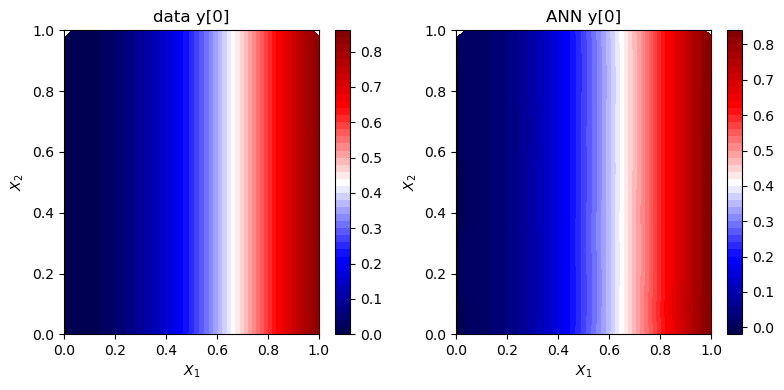

In [8]:
fig = plt.figure(figsize=[8,4])

ax = fig.add_subplot(121, xlabel=r'$X_1$', ylabel=r'$X_2$', title='data y[0]', xlim=[0,1], ylim=[0,1])
ct = ax.tricontourf(X[:, 0], X[:, 1], y[:, 0], 50)
plt.colorbar(ct)

ax = fig.add_subplot(122, xlabel=r'$X_1$', ylabel=r'$X_2$', title='ANN y[0]', xlim=[0,1], ylim=[0,1])
ct = ax.tricontourf(X[:, 0], X[:, 1], predictions[:, 0], 50)
plt.colorbar(ct)

plt.tight_layout()

### User defined loss

Now, let's say we wish to use the following (mean absolute) loss instead, which is not implemented:

\begin{align}
L = \frac{1}{n_{out}}\sum|y_j - {\bf h}_j|
\end{align}

We can define the loss function which returns $L$ and the corresponding loss gradient per output neuron per mini batch sample:

\begin{align}
\frac{\partial L}{\partial {\bf h}_j} = -\frac{1}{n_{out}}\mathrm{sign}({\bf y} - H)
\end{align}

The `sign` function acts elementwise.

This function **needs to have the arguments `(h, y)`, in this order**.

In [9]:
def user_defined_loss(h, y):
    """
    User defined mean absolute loss L = sum |y_j - h_j| / n_out.

    Parameters
    ----------
    h : array, shape (n_out, batch_size)
        The minibatch ANN prediction of y.
    y : array, shape (n_out, batch_size)
        The minibatch training data.

    Returns
    -------
    L_i : array, shape (n_out, batch_size)
        Elementwise loss function values.
    grad_L : array, shape (n_out, batch_size)
        Elementwise loss function gradient values.

    """

    loss = np.sum(np.abs(y - h), axis=0) / y.size
    dloss_dh = -np.sign(y - h) / y.size

    return loss, dloss_dh

We redefine the ANN, and just pass the user-defined loss function as `loss=user_defined_loss`

In [10]:
ANN = es.methods.ANN_Surrogate()

# number of mini batch iterations
n_iter = 5000

# train the ANN
ANN.train(X, y, n_iter,
          loss = user_defined_loss,
          n_neurons = 100, n_layers = 3, 
          batch_size=32)

Creating ANN_Surrogate Object
Creating Feature Engineering object
Using  10000/10000 samples to train the ML model
Neural net parameters
Number of layers = 3
Number of features = 2
Loss function = <function user_defined_loss at 0x7f0a180a8040>
Number of neurons per hidden layer = 100
Number of output neurons = 2
Activation = ['linear', 'tanh', 'tanh', 'linear']
This neural network has 10602 weights.
Training Artificial Neural Network...


  2%|██▉                                                                                                                                                                 | 91/5000 [00:00<00:05, 903.91it/s]

 loss = 0.0208


 24%|██████████████████████████████████████▍                                                                                                                           | 1188/5000 [00:01<00:03, 983.67it/s]

 loss = 0.0005


 44%|██████████████████████████████████████████████████████████████████████▊                                                                                           | 2184/5000 [00:02<00:02, 979.22it/s]

 loss = 0.0003


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 3096/5000 [00:03<00:01, 962.14it/s]

 loss = 0.0002


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 4178/5000 [00:04<00:00, 945.99it/s]

 loss = 0.0002


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:05<00:00, 975.94it/s]


Make predictions at training data

In [11]:
predictions = np.zeros([X.shape[0], n_out])
for i, x in enumerate(X):
    predictions[i] = ANN.predict(x)

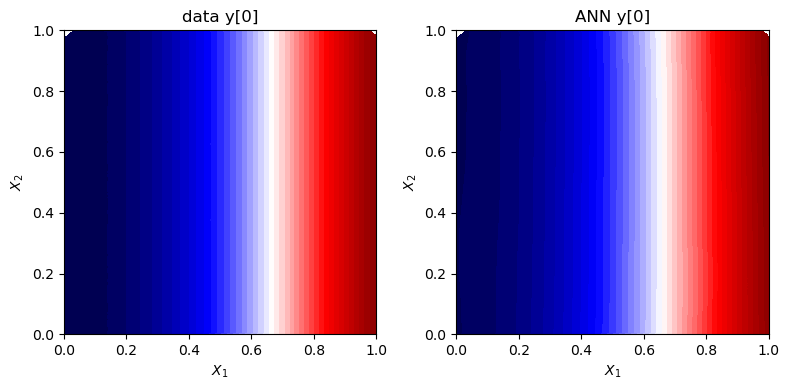

In [12]:
fig = plt.figure(figsize=[8,4])

ax = fig.add_subplot(121, xlabel=r'$X_1$', ylabel=r'$X_2$', title='data y[0]', xlim=[0,1], ylim=[0,1])
ax.tricontourf(X[:, 0], X[:, 1], y[:, 0], 50)

ax = fig.add_subplot(122, xlabel=r'$X_1$', ylabel=r'$X_2$', title='ANN y[0]', xlim=[0,1], ylim=[0,1])
ax.tricontourf(X[:, 0], X[:, 1], predictions[:, 0], 50)

plt.tight_layout()